# Praxis

In [1]:
import time
import numpy as np
import pandas as pd
import ringity as rng
import networkx as nx
import scipy.stats as ss
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.spatial.distance import pdist, squareform
from ringity.classes.network_model import NetworkBuilder

## Distribution

In [2]:
N = 2**12
beta = 0.523

rate  = np.tan(np.pi * (1-beta) / 2)
delay = 1 - 2/np.pi * np.arctan(rate)

network_builder = NetworkBuilder(random_state = 1234)
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)

In [3]:
assert np.isclose(delay, beta)

Given a wrapped exponential distribution with rate parameter $\lambda$, i.e. $\Theta\sim \mathit{WrapExp}(\lambda)$ the pdf can be expressed as
$$f_{\Theta}(t) = \frac{\lambda e^{-\lambda t}}{1-e^{-2\pi\lambda}} \; .$$

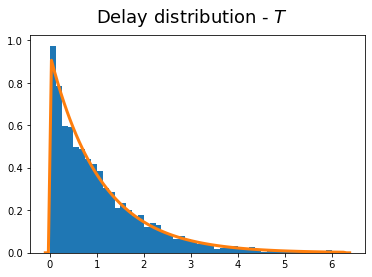

In [4]:
x = np.linspace(-0.1,2*np.pi+0.1,100)

plt.hist(network_builder.positions, density=True, bins=50);
plt.plot(x, rng.pdf_delay(x, rate, 'rate') , linewidth=3)

plt.suptitle("Delay distribution - $T$", fontsize=18);

In [5]:
mu1 = np.mean(network_builder._positions)
mu2 = quad(lambda x : x*rng.pdf_delay(x, rate, 'rate'), 0, 2*np.pi)[0]

print(mu1)
print(mu2)

1.0586428952145024
1.056757304047466


In [6]:
rv = ss.truncexpon(b = 2*np.pi*rate, scale = 1/rate)
rv.mean()

1.0567573040474658

In [7]:
ss.ks_1samp(network_builder._positions, rv.cdf)

KstestResult(statistic=0.017713199345091052, pvalue=0.15115724629722116)

## Distances and Similarity

In [134]:
N = 2**13
beta = np.random.uniform()
alpha = np.random.uniform(0, 0.5)

rate  = np.tan(np.pi * (1-beta) / 2)
delay = 2/np.pi * np.arctan(rate)

network_builder = NetworkBuilder(random_state = 1234)
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')

The circular distance is defined as $D = \min {\left\{ |X-Y|, 2\pi-|X-Y|\right\}}$. The corresponding pdf can be calculated via $f_{D}(t) = f_{|X-Y|}(t) + f_{|X-Y|}(2\pi-t)$ where $f_{|X-Y|}(t) = 2 \cdot f_{\Theta}(t) * f_{\Theta}(-t)$. This boils down to

$$f_{D}(t) = \frac {\lambda}{\sinh(\pi\lambda)}\cdot \cosh(\lambda \cdot (\pi-t)) \; .$$

The corresponding conditional density distribution is defined as $D_{\vartheta} = \min {\left\{ |X-\vartheta|, 2\pi-|X-\vartheta| \right\}}$ and can be calculated via $f_{D_{\vartheta}}(t) = f_{|X-\vartheta|}(t) + f_{|X-\vartheta|}(2\pi-t)$ where $f_{|X-\vartheta|}(t) = f_{\Theta}(\vartheta+t) + f_{\Theta}(\vartheta-t)$. This boils down to 

$$f_{D_{\vartheta}}(t) = \frac{2\lambda e^{-\lambda \vartheta}}{1 - e^{-2\pi\lambda}} \cdot
\begin{cases}
\cosh(\lambda t) & \text{, for } t \leq \min \{ \vartheta, 2\pi - \vartheta \} \\
\cosh(\lambda (\pi-t)) \cdot e^{\operatorname{sgn} (\vartheta - t) \lambda \pi}  & \text{, for } t \geq \min \{ \vartheta, 2\pi - \vartheta \} \; .
\end{cases}
$$

In [171]:
def pdf_conditional_absolute_distance(t, theta, rate):
    support = np.where((0 <= t) & (t <= 2*np.pi), 1, 0.)
    norm = rate / (1 - np.exp(-2*np.pi*rate))
    
    cond1 = (t <= theta) & (t <= 2*np.pi - theta)
    cond2 = (t >= theta) & (t <= 2*np.pi - theta)
    cond3 = (t <= theta) & (t >= 2*np.pi - theta)
    cond4 = (t >= theta) & (t >= 2*np.pi - theta)
    
    term1 = np.where(cond1, 2 * np.exp(-rate*theta) * np.cosh(rate*t), 1)
    term2 = np.where(cond2, np.exp(-rate*(theta+t)), 1)
    term3 = np.where(cond3, np.exp(-rate*(theta-t)), 1)
    term4 = np.where(cond4, 0, 1)
    
    term = term1*term2*term3*term4
    
    return support * norm * term

def pdf_conditional_circular_distance(t, theta, rate):
    support = np.where((0 <= t) & (t <= np.pi), 1, 0.)
    norm = 2*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
    
    cond1 = (t <= min(theta, 2*np.pi-theta))
    cond2 = (t >= min(theta, 2*np.pi-theta))
    
    term1 = np.where(cond1, np.cosh(rate*t), 1)
    term2 = np.where(cond2, np.cosh(rate*(np.pi-t)) * np.exp(np.sign(theta-t)*rate * np.pi), 1)
    
    term = term1*term2
    
    return support * norm * term

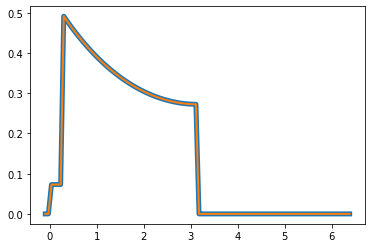

In [179]:
x = np.linspace(-0.1, 2*np.pi+0.1, 100)
theta = 6

fig, ax = plt.subplots()

ax.plot(x, rng.pdf_conditional_circular_distance(x, theta=theta, parameter=rate, parameter_type='rate'), 
        linewidth=5)
ax.plot(x, pdf_conditional_circular_distance(x, theta, rate) , linewidth=2)

In [180]:
%%timeit 

rng.pdf_conditional_circular_distance(x, theta=theta, parameter=rate, parameter_type='rate')

135 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [181]:
%%timeit

pdf_conditional_circular_distance(x, theta, rate)

86.8 µs ± 51.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


---

**For $a \leq 0.5$ (!)**, the similarity is defined as $S = \left| 1 - \frac{D}{2\pi a} \right|_{+}$. The corresponding pdf can be calculated via $f_{S}(t) = 2a\pi \cdot f_D \big(2a\pi(1-t) \big)$. This boils down to

$$f_{S}(t) = 
\begin{cases}
s_0 \delta_0 & \text{, for } t = 0 \\
\frac {2\pi a \lambda}{\sinh(\pi\lambda)} \cdot \cosh \Big(\lambda \pi \big(1-(2a-t)\big) \Big)& \text{, for } t \geq 0 \\
\end{cases}
 \; .$$

The corresponding conditional density distribution is defined as $S_{\vartheta} = \left| 1 - \frac{D_{\vartheta}}{2\pi a} \right|_{+}$ and can be calculated via $f_{S_{\vartheta}}(t) = 2a\pi \cdot f_{D_{\vartheta}} \big(2a\pi(1-t) \big)$. This boils down to 

$$f_{S_{\vartheta}}(t) = \frac{2\lambda e^{-\lambda \vartheta}}{1 - e^{-2\pi\lambda}} \cdot
\begin{cases}
\cosh(\lambda t) & \text{, for } t \leq \min \{ \vartheta, 2\pi - \vartheta \} \\
\cosh(\lambda (\pi-t)) \cdot e^{\operatorname{sgn} (\vartheta - t) \lambda \pi}  & \text{, for } t \geq \min \{ \vartheta, 2\pi - \vartheta \} \; .
\end{cases}
$$

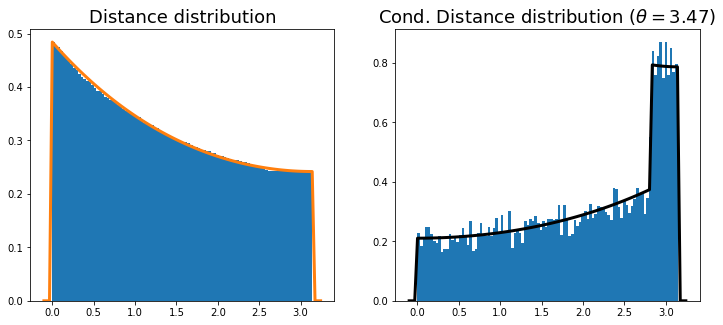

In [182]:
x = np.linspace(-0.1, np.pi+0.1, 100)

i = 100
theta = network_builder._positions[i]

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.hist(network_builder._distances, density=True, bins=100);
ax1.plot(x, rng.pdf_circular_distance(x, rate, 'rate') , linewidth=3)
ax1.set_title("Distance distribution", fontsize=18);

ax2.hist(network_builder.distances[i,:], density=True, bins=100);
ax2.plot(x, pdf_conditional_circular_distance(x, theta=theta, rate=rate) , linewidth=3, c='k')
ax2.set_title(rf"Cond. Distance distribution ($\theta = {theta:.2f}$)", fontsize=18);

In [191]:
def pdf_conditional_similarity(t, theta, a, rate):
    support = np.where((0 <= t) & (t <= 1), 1, 0.)
    norm = 4*a*np.pi*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
    
    cond1 = (2*a*np.pi*(1-t) <= min(theta, 2*np.pi-theta))
    cond2 = (2*a*np.pi*(1-t) >= min(theta, 2*np.pi-theta))
    
    term1 = np.where(cond1, np.cosh(rate*2*a*np.pi*(1-t)), 1)
    term2 = np.where(cond2, np.cosh(rate*np.pi*(1-2*a*(1-t))) * np.exp(np.sign(theta-2*a*np.pi*(1-t))*rate * np.pi), 1)
    
    term = term1*term2
    
    return support * norm * term

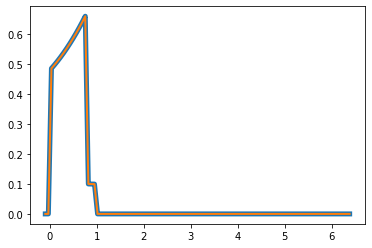

In [199]:
x = np.linspace(-0.1, 2*np.pi+0.1, 100)
theta = 6

fig, ax = plt.subplots()

ax.plot(x, rng.pdf_conditional_similarity(x, 
                                          theta=theta, 
                                          a=alpha,
                                          parameter=rate, 
                                          parameter_type='rate'), 
        linewidth=5)
ax.plot(x, pdf_conditional_similarity(x, theta=theta, a=alpha, rate=rate) , linewidth=2)

In [143]:
mu1 = np.mean(network_builder._distances)
mu2 = quad(lambda x : x*rng.pdf_circular_distance(x, rate, 'rate'), 0, 2*np.pi)[0]

print(mu1)
print(mu2)

1.379216264668126
1.3769294515818054


In [144]:
disc_part = 2*(network_builder._similarities!=0).sum() / (N*(N-1))

(0.0, 5.0)

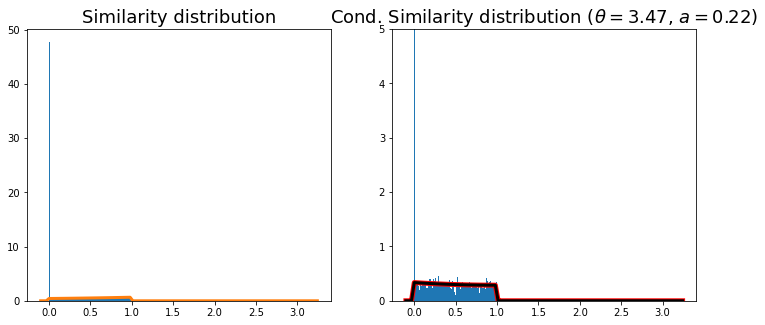

In [161]:
x = np.linspace(-0.1, np.pi+0.1, 100)

i = 100
theta = network_builder._positions[i]

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.hist(network_builder._similarities, density=True, bins=100);
ax1.plot(x, rng.pdf_similarity(x, parameter=rate, parameter_type='rate', a=alpha) , linewidth=3)
ax1.set_title("Similarity distribution", fontsize=18);

ax2.hist(network_builder.similarities[i,:], density=True, bins=100);
ax2.plot(x, rng.pdf_conditional_similarity(x, theta=theta, parameter=rate, a=alpha) , linewidth=5, c='r')
ax2.plot(x, pdf_conditional_similarity(x, theta=theta, rate=rate, a=alpha) , linewidth=3, c='k')
ax2.set_title(rf"Cond. Similarity distribution ($\theta = {theta:.2f}$, $a = {alpha:.2f}$)", fontsize=18);

ax2.set_ylim(0, 5)

In [162]:
%%timeit 

rng.pdf_conditional_similarity(x, theta=theta, a=alpha, parameter=rate, parameter_type='rate')

210 µs ± 17.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [163]:
%%timeit

pdf_conditional_similarity(x, theta=theta, rate=rate, a=alpha)

65.8 µs ± 450 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
mu1 = np.mean(network_builder._similarities)
mu2 = quad(lambda x : x*rng.pdf_similarity(x, parameter = rate, a=alpha, parameter_type='rate'), 
           0, 2*np.pi)[0]

print(mu1)
print(mu2)

0.1700778912539887
0.1711946922967755


In [19]:
rng.classes.network_model.mean_similarity(a=alpha, rate = rate)

0.1711946922137414

In [20]:
def mean_similarity(rate, a):
    """Calculate expected mean similarity (equivalently maximal expected density). 
    
    This function assumies a (wrapped) exponential function and a cosine similarity 
    of box functions.
    """
    palph = a*2
    plamb = np.pi * rate
    
    # Alternatively:
    numerator = 2*(np.sinh(plamb*(1-a)) * np.sinh(plamb*a))
#    numerator = (np.cosh(plamb) - np.cosh(plamb*(1 - palph)))
    denominator = (palph*plamb * np.sinh(plamb))
    
    return 1 - numerator / denominator 

In [21]:
mean_similarity(a=alpha, rate = rate)

0.1711946922137414

## Probability

In [51]:
N = 2**9
beta = np.random.uniform()
alpha = np.random.uniform(0, 0.5)

rate  = np.tan(np.pi * (1-beta) / 2)

max_rho = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)
rho = np.random.uniform(0, max_rho)

K = rng.classes.network_model.density_to_interaction_strength(rho, a=alpha, rate=rate)
density = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)*K

network_builder = NetworkBuilder()
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')
network_builder.calculate_probabilities(intercept=0, slope = K)
network_builder.instantiate_network()

In [52]:
assert np.isclose(rho, density)

In [53]:
disc_part = 2*(network_builder._probabilities!=0).sum() / (N*(N-1))

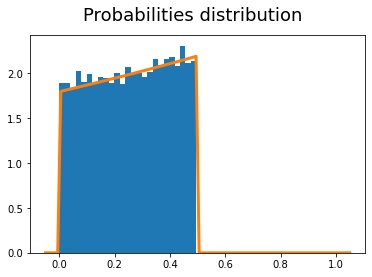

In [54]:
x = np.linspace(-0.05, 1.05, 100)

plt.hist(network_builder._probabilities[network_builder._probabilities != 0], density=True, bins=25);
plt.plot(x, rng.pdf_probability(x, 
                                rho = rho,
                                parameter = rate, 
                                a = alpha, 
                                parameter_type = 'rate')/disc_part , linewidth=3)

plt.suptitle("Probabilities distribution", fontsize=18);

In [55]:
mu1 = np.mean(network_builder._probabilities)
mu2 = quad(lambda x : x*rng.pdf_probability(x, parameter = rate, a=alpha, rho=rho, parameter_type='rate'), 
           0, 2*np.pi)[0]

print(mu1)
print(mu2)

0.04683326319551728
0.04644061639041624


# Conditional distributions

## Conditional Distances and Similarity

In [56]:
# Pipeline

N = 2**13
beta = np.random.uniform()
alpha = np.random.uniform(0, 0.5)

rate  = np.tan(np.pi * (1-beta) / 2)
delay = 2/np.pi * np.arctan(rate)

network_builder = NetworkBuilder(random_state = 1234)
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')

theta = network_builder.positions[0]

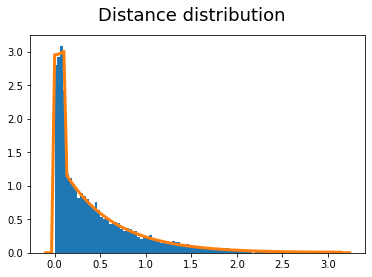

In [63]:
x = np.linspace(-0.1, np.pi+0.1, 100)

plt.hist(network_builder.distances[0], density=True, bins=100);
plt.plot(x, rng.pdf_conditional_circular_distance(x, 
                                                  theta=theta, 
                                                  parameter=rate, 
                                                  parameter_type='rate') , linewidth=3)

plt.suptitle("Distance distribution", fontsize=18);

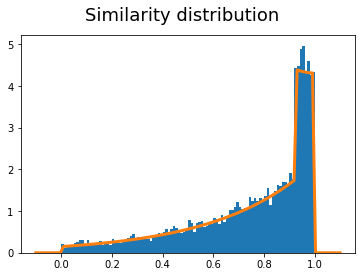

In [72]:
x = np.linspace(-0.1, 1.1, 100)

similarities = network_builder.similarities[0]
disc_part = 2*(similarities!=0).sum() / (N*(N-1))

plt.hist(similarities[similarities!=0], density=True, bins=100);
plt.plot(x, rng.pdf_conditional_similarity(x, 
                                           theta = theta,
                                           parameter = rate, 
                                           a = alpha, 
                                           parameter_type = 'rate') , linewidth=3)

plt.suptitle("Similarity distribution", fontsize=18);

## Conditional probabilities

In [88]:
N = 2**9
beta = np.random.uniform()
alpha = np.random.uniform(0, 0.5)

rate  = np.tan(np.pi * (1-beta) / 2)

max_rho = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)
rho = np.random.uniform(0, max_rho)

K = rng.classes.network_model.density_to_interaction_strength(rho, a=alpha, rate=rate)
density = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)*K

network_builder = NetworkBuilder()
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')
network_builder.calculate_probabilities(intercept=0, slope = K)
network_builder.instantiate_network()

theta = network_builder.positions[0]

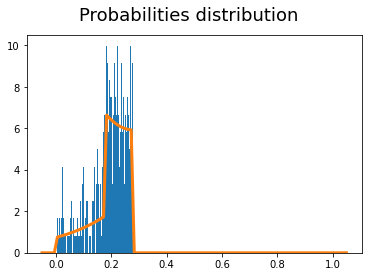

In [89]:
x = np.linspace(-0.05, 1.05, 100)

probabilities = network_builder.probabilities[0]
disc_part = 2*(probabilities!=0).sum() / (N*(N-1))

plt.hist(probabilities[probabilities!=0], density=True, bins=100);

plt.plot(x, rng.pdf_conditional_probability(x, 
                                            theta = theta,
                                            rho = rho,
                                            parameter = rate, 
                                            a = alpha, 
                                            parameter_type = 'rate') , linewidth=3)

plt.suptitle("Probabilities distribution", fontsize=18);